In [1]:
pwd


'/content'

In [2]:
!git clone https://github.com/theschoolof-ai/JEDI.git

Cloning into 'JEDI'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 309 (delta 18), reused 11 (delta 3), pack-reused 256
Receiving objects: 100% (309/309), 158.92 MiB | 40.18 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [3]:
cd /content/JEDI/tsai.jedi

/content/JEDI/tsai.jedi


In [4]:
ls

aftereffects.py  datatransforms.py     main.py         README.md
batchnorm.py     Engine_train_test.py  model_objects/  S9_resnet.py
config.py        gradcam.py            Models/
dataloader.py    lr_finder.py          __pycache__/


In [5]:
import sys
sys.path.append('Models/')
from S8_resnet import ResNet18
from S7 import model_summary

In [6]:
import sys
sys.path.append('Models/')
from S7 import model_summary
from S9_resnet import resnet18

In [7]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 9.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=9b8acb22efcec6c59a3b14838fb5acadf7372bf76b895521360eb6f92e2c3293
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [8]:
sys.path.append(".")
%matplotlib inline
import torch
import config
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from Engine_train_test import train, test
# Cutout instroduced in train_loader_CIFAR10_alb
from dataloader import train_loader_CIFAR10_alb, test_loader_CIFAR10_alb
from aftereffects import get_image_with_target, plots
from lr_finder import LRFinder
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
import config

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified



In [9]:
model_ = resnet18(num_classes = 10,pretrained = False).to(config.device)
print(model_summary(model_, config.input_size_CIFAR10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


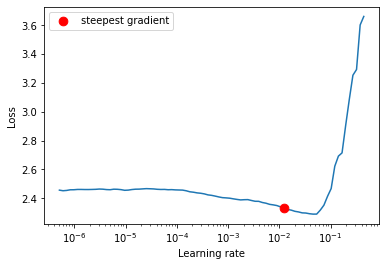

In [11]:

%matplotlib inline

import torch.nn as nn
import torch.optim as optim
from __future__ import print_function
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


# SGD with momentum for lr_finder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_alb, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()





In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
valid_acc = []
valid_loss = []
train_acc = []
train_loss = []
l1_regularization = [0, 0]

# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

# Assign optimizer with suggested learning rate and run it with reduceonpleatue
optimizer = optim.SGD(model_.parameters(), lr=1.23E-02,  momentum=0.9, weight_decay=5e-4) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
for epoch in range(50):
    train_a, train_l = train(model_, config.device, train_loader_CIFAR10_alb, optimizer, epoch, l1_regularization=[0, 1])
    #scheduler.step()
    train_acc.append(train_a)
    train_loss.append(train_l)
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    valid_loss.append(valid_l)
    # Note that step should be called after validate()
    scheduler.step(valid_l)

Epoch: 0,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 19351/50000 (38.7020%)



loss=1.2994922399520874 batch_id=0:   0%|          | 1/391 [00:00<00:51,  7.53it/s]


Test set: Average loss: 0.0104, Accuracy: 5178/10000 (51.7800%)



Epoch: 1,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 27132/50000 (54.2640%)



loss=1.0001424551010132 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.23it/s]


Test set: Average loss: 0.0094, Accuracy: 5765/10000 (57.6500%)



Epoch: 2,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 31112/50000 (62.2240%)



loss=0.9049221277236938 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.27it/s]


Test set: Average loss: 0.0082, Accuracy: 6426/10000 (64.2600%)



Epoch: 3,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 33937/50000 (67.8740%)



loss=0.7538567185401917 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.16it/s]


Test set: Average loss: 0.0068, Accuracy: 7016/10000 (70.1600%)



Epoch: 4,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 36031/50000 (72.0620%)



loss=0.7207642793655396 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.25it/s]


Test set: Average loss: 0.0056, Accuracy: 7475/10000 (74.7500%)



Epoch: 5,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 37620/50000 (75.2400%)



loss=0.7013107538223267 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.04it/s]


Test set: Average loss: 0.0052, Accuracy: 7721/10000 (77.2100%)



Epoch: 6,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 38646/50000 (77.2920%)



loss=0.5073297023773193 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.13it/s]


Test set: Average loss: 0.0047, Accuracy: 7951/10000 (79.5100%)



Epoch: 7,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 39602/50000 (79.2040%)



loss=0.42943888902664185 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.27it/s]


Test set: Average loss: 0.0043, Accuracy: 8174/10000 (81.7400%)



Epoch: 8,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 40467/50000 (80.9340%)



loss=0.3686527609825134 batch_id=0:   0%|          | 1/391 [00:00<00:51,  7.56it/s]


Test set: Average loss: 0.0047, Accuracy: 8028/10000 (80.2800%)



Epoch: 9,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 41104/50000 (82.2080%)



loss=0.4244209825992584 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.36it/s]


Test set: Average loss: 0.0044, Accuracy: 8161/10000 (81.6100%)



Epoch: 10,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 41679/50000 (83.3580%)



loss=0.3503442704677582 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.14it/s]


Test set: Average loss: 0.0041, Accuracy: 8323/10000 (83.2300%)



Epoch: 11,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 42126/50000 (84.2520%)



loss=0.3082427382469177 batch_id=0:   0%|          | 1/391 [00:00<00:59,  6.59it/s]


Test set: Average loss: 0.0040, Accuracy: 8293/10000 (82.9300%)



Epoch: 12,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 42698/50000 (85.3960%)



loss=0.268296480178833 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.36it/s]


Test set: Average loss: 0.0041, Accuracy: 8299/10000 (82.9900%)



Epoch: 13,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 43072/50000 (86.1440%)



loss=0.5178850889205933 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.34it/s]


Test set: Average loss: 0.0040, Accuracy: 8325/10000 (83.2500%)



Epoch: 14,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 43341/50000 (86.6820%)



loss=0.3605104088783264 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.33it/s]


Test set: Average loss: 0.0041, Accuracy: 8262/10000 (82.6200%)



Epoch: 15,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 43672/50000 (87.3440%)



loss=0.3311556577682495 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.41it/s]


Test set: Average loss: 0.0041, Accuracy: 8357/10000 (83.5700%)



Epoch: 16,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 43938/50000 (87.8760%)



loss=0.22866536676883698 batch_id=0:   0%|          | 1/391 [00:00<00:55,  6.98it/s]


Test set: Average loss: 0.0038, Accuracy: 8448/10000 (84.4800%)



Epoch: 17,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 44242/50000 (88.4840%)



loss=0.23806920647621155 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.37it/s]


Test set: Average loss: 0.0042, Accuracy: 8342/10000 (83.4200%)



Epoch: 18,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 44588/50000 (89.1760%)



loss=0.32302024960517883 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.34it/s]


Test set: Average loss: 0.0038, Accuracy: 8501/10000 (85.0100%)



Epoch: 19,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 44749/50000 (89.4980%)



loss=0.29240313172340393 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.44it/s]


Test set: Average loss: 0.0035, Accuracy: 8569/10000 (85.6900%)



Epoch: 20,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 44770/50000 (89.5400%)



loss=0.2389233559370041 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.32it/s]


Test set: Average loss: 0.0043, Accuracy: 8332/10000 (83.3200%)



Epoch: 21,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45055/50000 (90.1100%)



loss=0.34503310918807983 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.32it/s]


Test set: Average loss: 0.0034, Accuracy: 8604/10000 (86.0400%)



Epoch: 22,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45370/50000 (90.7400%)



loss=0.20958615839481354 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.34it/s]


Test set: Average loss: 0.0038, Accuracy: 8566/10000 (85.6600%)



Epoch: 23,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45383/50000 (90.7660%)



loss=0.21211694180965424 batch_id=0:   0%|          | 1/391 [00:00<00:56,  6.90it/s]


Test set: Average loss: 0.0039, Accuracy: 8531/10000 (85.3100%)



Epoch: 24,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45538/50000 (91.0760%)



loss=0.24941915273666382 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.05it/s]


Test set: Average loss: 0.0035, Accuracy: 8648/10000 (86.4800%)



Epoch: 25,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45604/50000 (91.2080%)



loss=0.2345149666070938 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.07it/s]


Test set: Average loss: 0.0044, Accuracy: 8383/10000 (83.8300%)



Epoch: 26,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 45922/50000 (91.8440%)



loss=0.22404293715953827 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.27it/s]


Test set: Average loss: 0.0034, Accuracy: 8673/10000 (86.7300%)



Epoch: 27,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46018/50000 (92.0360%)



loss=0.293088436126709 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.18it/s]


Test set: Average loss: 0.0038, Accuracy: 8531/10000 (85.3100%)



Epoch: 28,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46134/50000 (92.2680%)



loss=0.30035167932510376 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.04it/s]


Test set: Average loss: 0.0034, Accuracy: 8720/10000 (87.2000%)



Epoch: 29,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46125/50000 (92.2500%)



loss=0.11975130438804626 batch_id=0:   0%|          | 1/391 [00:00<00:58,  6.66it/s]


Test set: Average loss: 0.0039, Accuracy: 8568/10000 (85.6800%)



Epoch: 30,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46322/50000 (92.6440%)



loss=0.13839015364646912 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.04it/s]


Test set: Average loss: 0.0038, Accuracy: 8576/10000 (85.7600%)



Epoch: 31,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46326/50000 (92.6520%)



loss=0.2668735980987549 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.31it/s]


Test set: Average loss: 0.0032, Accuracy: 8737/10000 (87.3700%)



Epoch: 32,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46315/50000 (92.6300%)



loss=0.2739677131175995 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.17it/s]


Test set: Average loss: 0.0049, Accuracy: 8313/10000 (83.1300%)



Epoch: 33,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46558/50000 (93.1160%)



loss=0.25468340516090393 batch_id=0:   0%|          | 1/391 [00:00<00:56,  6.95it/s]


Test set: Average loss: 0.0037, Accuracy: 8608/10000 (86.0800%)



Epoch: 34,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46515/50000 (93.0300%)



loss=0.2071632742881775 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.05it/s]


Test set: Average loss: 0.0031, Accuracy: 8772/10000 (87.7200%)



Epoch: 35,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46673/50000 (93.3460%)



loss=0.11965885758399963 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.46it/s]


Test set: Average loss: 0.0034, Accuracy: 8706/10000 (87.0600%)



Epoch: 36,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46682/50000 (93.3640%)



loss=0.17451807856559753 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.31it/s]


Test set: Average loss: 0.0034, Accuracy: 8678/10000 (86.7800%)



Epoch: 37,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46709/50000 (93.4180%)



loss=0.1665797084569931 batch_id=0:   0%|          | 1/391 [00:00<00:55,  7.06it/s]


Test set: Average loss: 0.0035, Accuracy: 8647/10000 (86.4700%)



Epoch: 38,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46697/50000 (93.3940%)



loss=0.14501391351222992 batch_id=0:   0%|          | 1/391 [00:00<00:54,  7.16it/s]


Test set: Average loss: 0.0033, Accuracy: 8724/10000 (87.2400%)



Epoch: 39,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46831/50000 (93.6620%)



loss=0.13766561448574066 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.22it/s]


Test set: Average loss: 0.0035, Accuracy: 8740/10000 (87.4000%)



Epoch: 40,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46927/50000 (93.8540%)



loss=0.09612763673067093 batch_id=0:   0%|          | 1/391 [00:00<00:51,  7.53it/s]


Test set: Average loss: 0.0034, Accuracy: 8726/10000 (87.2600%)



Epoch: 41,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46985/50000 (93.9700%)



loss=0.2434626668691635 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.37it/s]


Test set: Average loss: 0.0038, Accuracy: 8637/10000 (86.3700%)



Epoch: 42,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 46947/50000 (93.8940%)



loss=0.26359492540359497 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.28it/s]


Test set: Average loss: 0.0035, Accuracy: 8711/10000 (87.1100%)



Epoch: 43,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47041/50000 (94.0820%)



loss=0.19375744462013245 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.27it/s]


Test set: Average loss: 0.0029, Accuracy: 8853/10000 (88.5300%)



Epoch: 44,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47071/50000 (94.1420%)



loss=0.16547344624996185 batch_id=0:   0%|          | 1/391 [00:00<00:52,  7.46it/s]


Test set: Average loss: 0.0034, Accuracy: 8768/10000 (87.6800%)



Epoch: 45,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47066/50000 (94.1320%)



loss=0.23475655913352966 batch_id=0:   0%|          | 1/391 [00:00<00:51,  7.62it/s]


Test set: Average loss: 0.0031, Accuracy: 8800/10000 (88.0000%)



Epoch: 46,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47191/50000 (94.3820%)



loss=0.12968550622463226 batch_id=0:   0%|          | 1/391 [00:00<00:59,  6.60it/s]


Test set: Average loss: 0.0034, Accuracy: 8715/10000 (87.1500%)



Epoch: 47,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47045/50000 (94.0900%)



loss=0.1487586498260498 batch_id=0:   0%|          | 1/391 [00:00<00:53,  7.35it/s]


Test set: Average loss: 0.0031, Accuracy: 8814/10000 (88.1400%)



Epoch: 48,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47257/50000 (94.5140%)



loss=0.1031528189778328 batch_id=0:   0%|          | 1/391 [00:00<00:51,  7.60it/s]


Test set: Average loss: 0.0034, Accuracy: 8759/10000 (87.5900%)



Epoch: 49,LR: 0.0123.
Train set: train Average loss: 0.0000, train_Accuracy: 47231/50000 (94.4620%)


Test set: Average loss: 0.0032, Accuracy: 8829/10000 (88.2900%)



In [13]:
# Save the model
torch.save(model_, '/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt')

### Train Vs Validation Plots

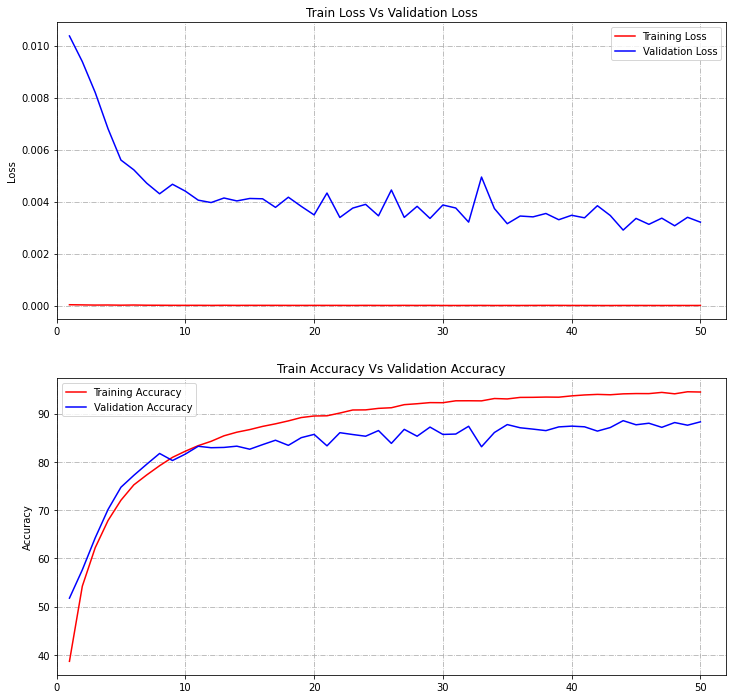

In [17]:
# 
import matplotlib.pyplot as plt
epoch = 50
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Loss')
plt.title('Train Loss Vs Validation Loss')
plt.plot(range(1, epoch+1), train_loss[:epoch+1], 'r', label='Training Loss')
plt.plot(range(1, epoch+1), valid_loss[:epoch+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)

ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.title('Train Accuracy Vs Validation Accuracy')
plt.plot(range(1, epoch+1), train_acc[:epoch+1], 'r', label='Training Accuracy')
plt.plot(range(1, epoch+1), valid_acc[:epoch+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [ ]:
# Plot Train Vs Validation acc Plot


In [18]:
PATH='/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt'
model = torch.load(PATH)
model.eval()

tot = 0
data_ = []
target_ = []
pred_ = []
correct = 0
tot_correct = 0
indx = []

for data, target in test_loader_CIFAR10_alb:
  data, target = data.to(config.device), target.to(config.device)
  output = model(data)
  #pred = output.cpu().data.numpy().argmax(dim=1, keepdim=True)  # get the index of the max log-probability
  pred = output.argmax(dim=1, keepdim=True) 
  correct += pred.eq(target.view_as(pred)).sum().item()
  equals = pred.eq(target.view_as(pred)).tolist()
    
  for idx in range(0,len(equals)):
    if equals[idx] == [False]:
      indx.append(idx)
      data_.append(data[idx])
      target_.append(target[idx])
      pred_.append(pred[idx])


  if len(indx) > 25:
    break
	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

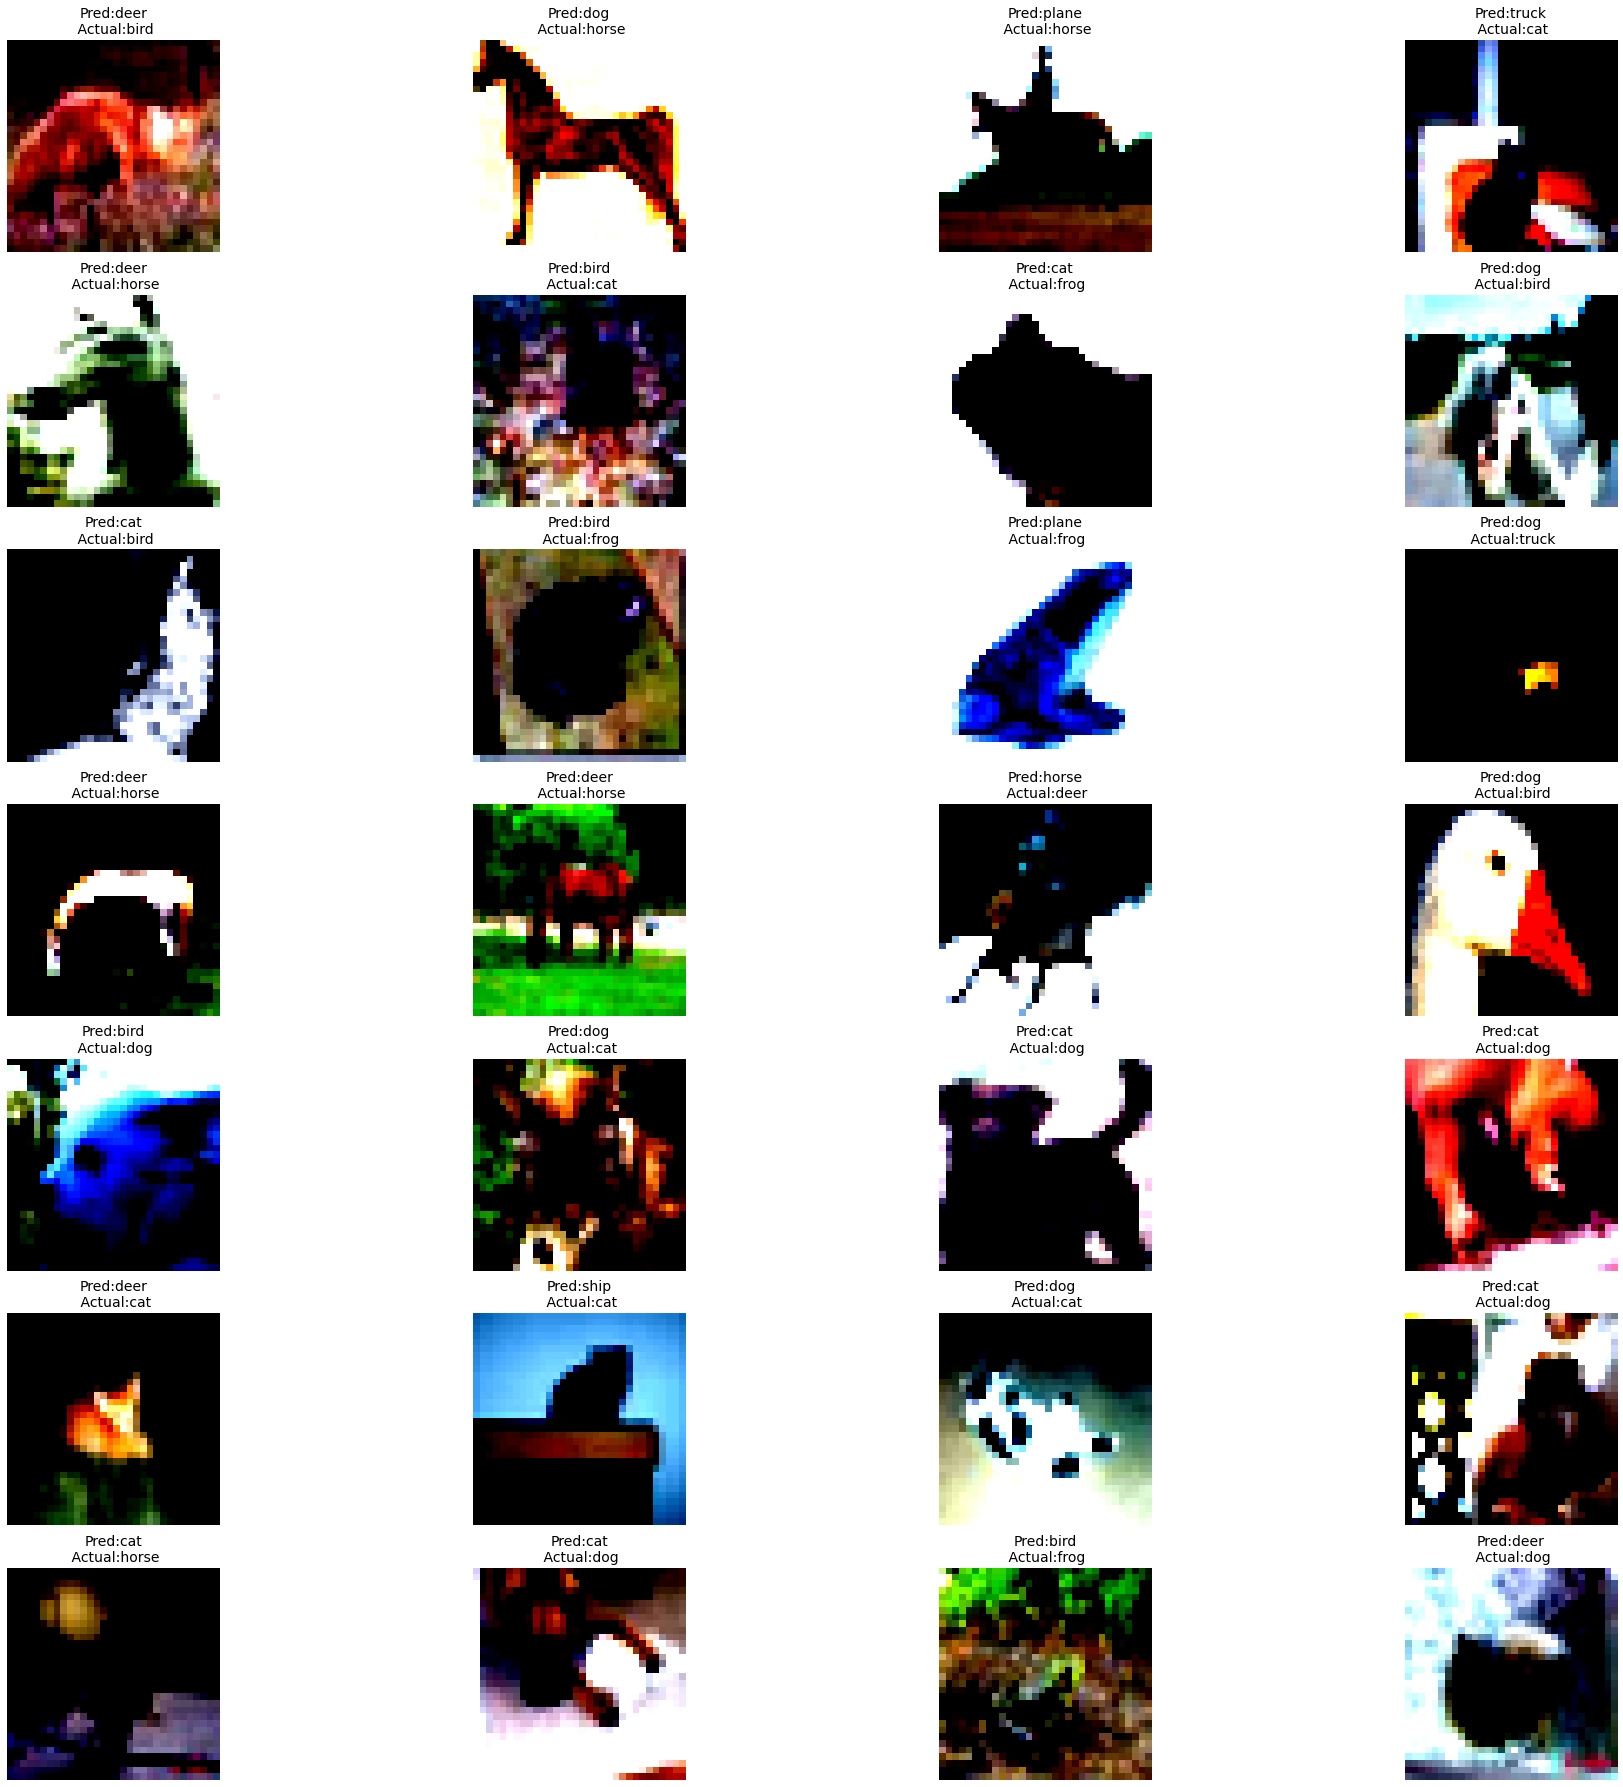

In [22]:
import numpy
import dataloader

classes_CIFAR10 = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# plots images with labels within jupyter notebook
def plots(ims, figsize=(32,32), rows=7, interp=False,titles = None,actual_label=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None and actual_label is not None:
            sp.set_title("Pred:{}\n Actual:{}".format(classes_CIFAR10[titles[i]],
                                                    classes_CIFAR10[actual_label[i]]), fontsize=14)
            
        sp.axis('Off')
        
        plt.imshow(torch.squeeze(ims[i]).permute(1,2,0).tolist() )

plots(data_,titles = pred_,actual_label=target_)

In [24]:
#################gradcam for misclassified images ################
import config
from gradcam import GradCam
from gradcam import show_cam_on_image
gradcam_img = []
for idx in range(len(data_)): 
    #ip = data_.index_select(0,torch.tensor(idx))
    ip = data_[idx].permute(1,2,0)
    #print(((data_[idx].shape)))
    grad_cam = GradCam(model=model, feature_module=model.layer3,target_layer_names=["1"], use_cuda=config.use_cuda)
    mask = grad_cam(ip)
    op_img = show_cam_on_image(ip.squeeze().permute(1,2,0), mask)
    gradcam_img.append(op_img)
#plots(gradcam_img,titles=target_t )
plots(data_,titles = pred_,actual_label=target_)


RuntimeError: ignored